In [1]:
import statistics as st
import squarify
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math
import plotly.express as px

In [199]:
import plotly.express as px

In [2]:
def preprocessing_d_w(df):
    df.columns = [c.replace(' ', '_') for c in df.columns]
    df['Date_Time'] = pd.to_datetime(df['Date_Time'], errors='coerce')
    df['date']=df.Date_Time.dt.date
    df['hour']=df.Date_Time.dt.hour
    df['weekday']=df.Date_Time.dt.weekday
    dt=df[['date','weekday','Actual_Talk_Time','Wait_Time','Queue_Time(Secs)','Call_Status']].copy()
    dt['date']=dt['date'].astype('datetime64[ns]')
    #Preprocess Actual_Talk_Time column
    dt['Actual_Talk_Time']=dt['Actual_Talk_Time'].str.replace('.', ':')
    x=dt['Actual_Talk_Time'].copy()
    #Putting NaNs at where data is is irregular 
    for i  in range(0,x.shape[0]):
        if ':' not in str(x.iloc[i]):
            x.iloc[i]=np.NaN
        if len(str(x.iloc[i])) > 8:
            x.iloc[i]=np.NaN
    dt['Actual_Talk_Time']=x
    return dt

def make_delta(entry):
    h, m, s = entry.split(':')
    return datetime.timedelta(hours=int(h), minutes=int(m), seconds=int(s))

def get_time_spent(df):
    pd.options.mode.chained_assignment = None
    dt=df.dropna(subset=['Actual_Talk_Time','date']) 
    dt['Actual_Talk_Time']=dt['Actual_Talk_Time'].map(lambda entry: make_delta(entry))
    l=pd.unique(dt.date.dt.month)
    l=sorted(l)
    m=['NO_MONTH','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
    k=[]
    at_mon_wise=[]
    for i in l:
        k.append(m[i])
        dt_mon=dt[dt.date.dt.month==i]
        #Initialise an empty timedelta object
        s=datetime.timedelta(hours=int(0), minutes=int(0), seconds=int(0))
        for idx,row in dt_mon.iterrows():
            s=s+row['Actual_Talk_Time']
       # print(s)
        at_mon_wise.append(round(s/np.timedelta64(1, 'h')))
    stats=pd.DataFrame({'month':k,'talktime_percentage':at_mon_wise})
    stats['talktime_percentage']=round(stats['talktime_percentage']*100/sum(at_mon_wise))
    pd.options.mode.chained_assignment = "warn"
    return stats,sum(at_mon_wise)

#Number of calls monthwise 
def get_monthwise_stats(df):
    l=pd.unique(df.date.dt.month)
    l=sorted(l)
    m=['NO_MONTH','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
    k=[]
    call_count_mon_wise=[]
    for i in l:
        k.append(m[i])
        call_count_mon_wise.append(df[df.date.dt.month==i].sum().counts)
    s=sum(call_count_mon_wise)
    stats=pd.DataFrame({'month':k,'call_number_percentage':call_count_mon_wise})
    stats['call_number_percentage']=round(stats['call_number_percentage']*100/s)
    stats=stats.reset_index(drop=True)
    return stats

#Takes top 3 months from every year which are having max and least number of calls and returned by m and l variable respectively
def get_top_max_least_values(*dfs,based_on_col,col_to_get):
    l=[]
    for df in dfs:
        l=l+get_top_three(df.sort_values(based_on_col).reset_index(drop=True),based_on_col,col_to_get)
    l=pd.DataFrame({col_to_get:l})
    l=l.groupby(col_to_get).size().reset_index(name='percentage')
    l['percentage']=round(l['percentage']*100/len(dfs),2)
    l=l.sort_values('percentage',ascending=False)
    l=l.reset_index(drop=True)
    l['label']=l[col_to_get].astype(str)+':'+l['percentage'].astype(str)+'%'
    #print(l,'L')
    m=[]
    for df in dfs:
        m=m+get_top_three(df.sort_values(based_on_col,ascending=[False]).reset_index(drop=True),based_on_col,col_to_get)
    m=pd.DataFrame({col_to_get:m})
    m=m.groupby(col_to_get).size().reset_index(name='percentage')
    m['percentage']=round(m['percentage']*100/len(dfs),2)
    m=m.sort_values('percentage',ascending=False)
    m=m.reset_index(drop=True)
    m['label']=m[col_to_get].astype(str)+':'+m['percentage'].astype(str)+'%'
    return m,l

def time_spent_plotter(df):
    sns.barplot(x="month", y="talk_time", data=df, palette=get_colors_for_values(df['talk_time'], "YlOrRd"));

def get_colors_for_values(values, palette_name):
    normalized = (values - min(values)) / (max(values) - min(values))
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

def get_counts_of_calls_everyday(df):
    dt=df.groupby(['date']).size().reset_index(name='counts')
    return dt

#def check_if_poisson(df):
def normalize(df):
    return(df-df.min())/(df.max()-df.min())
def confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return (round(float(m-h),2),round(float(m),2),round(float(m+h),2))
def outlier_rem(df):
    flag=True
    # As it is having outliers which is of kind like when one outlier is removed then with new standard dev another outlier 
    # is spotted so to handle that while loop is added , further dbscan can be taken into consideration 
    while(flag):
        flag=False
        x=df['Queue_Time(Secs)']
        std=st.stdev(x)
        m=x.mean()
        lower=m-3.5*std
        upper=m+3.5*std
        #If you will print index "i" it will not be the expected one as index of df passed here 
        #but its not the case in this series becoz thats a subset of df passed but this functionlity will work fine as its 
        #not dependedent on that.
        idx=[]
        for i  in range(0,x.shape[0]):
            if x.iloc[i]<lower or x.iloc[i]>upper:
                idx.append(i)
                flag=True
        df=df.drop(df.index[idx])
    return df
def get_monthly_callstatus_stats(df):
    df=df.dropna(subset=['date'])
    dt=df[df.Call_Status.isin(['answered','abandon'])]
    dt=df[['date','Call_Status']].copy()
    dt['month']=df.date.dt.month
    dt=dt.groupby(['month','Call_Status']).size().reset_index(name='counts')
    l=pd.unique(df.date.dt.month)
    l=sorted(l)
    m=['NO_MONTH','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
    k=[]
    dt_ans=dt[dt['Call_Status']=='answered']
    dt_abn=dt[dt['Call_Status']=='abandon']
    #call_count_ans=[]
    call_count_abn=[]
    for i in l:
        k.append(m[int(i)])
        x_ans=dt_ans[dt_ans['month']==int(i)]
        x_abn=dt_abn[dt_abn['month']==int(i)]
    #    call_count_ans.append(int(x_ans['counts'])*100/(int(x_ans['counts'])+int(x_abn['counts'])))
        call_count_abn.append(int(x_abn['counts'])*100/(int(x_ans['counts'])+int(x_abn['counts'])))
    #s_ans=sum(call_count_ans)
    s_abn=sum(call_count_abn)
    #stats_ans=pd.DataFrame({'month':k,'percentage_answered_calls':call_count_ans})
    #stats_ans['percentage_answered_calls']=round(stats_ans['percentage_answered_calls'],2)
    #stats_ans=stats_ans.reset_index(drop=True)
    stats_abn=pd.DataFrame({'month':k,'percentage_unanswered_calls':call_count_abn})
    stats_abn['percentage_unanswered_calls']=round(stats_abn['percentage_unanswered_calls'])
    stats_abn=stats_abn.reset_index(drop=True)
    stats_abn['label']=stats_abn['month']+':'+stats_abn['percentage_unanswered_calls'].astype(str)+'%'
    return  stats_abn    

def plot_treemap(df,col_based_on,label,title):
    squarify.plot(sizes=df[col_based_on], label=df[label], alpha=.7 )
    plt.axis('off')
    plt.title(title) 
    plt.show()

def plot_treemap_sidebyside(df1,df2,col_based_on,label,title1,title2):
    plt.figure(num=None, figsize=(14.3, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(1, 2, 1)
    squarify.plot(sizes=df1[col_based_on], label=df1[label], alpha=.7 )
    plt.axis('off')
    plt.title(title1) 
    plt.subplot(1, 2, 2)
    squarify.plot(sizes=df2[col_based_on], label=df2[label], alpha=.7 )
    plt.axis('off')
    plt.title(title2) 

    plt.show()  
    
def plot_queuetime_stats(*dfs):
    for df in dfs:
        df=pd.concat([df[['Queue_Time(Secs)','Call_Status']]])
    df_unans=df[df['Call_Status']=='abandon']
    count=np.zeros(4)
    size=df_unans['Queue_Time(Secs)'].shape[0]
    for i in df_unans['Queue_Time(Secs)']:
        if i > 50 and i <= 60:
            count[3]+=1
        elif i>40 and i<=50:
            count[2]+=1
        elif i>20 and i<=40:
            count[1]+=1
        elif i>0 and i<=20:
            count[0]+=1
    qt_per=np.round(count*100/size, 2)
    l=['0s to 20s','20s to 40s','40s to 50s','50s to 60s']
    qt=pd.DataFrame({'label':l,'queuetime':qt_per})
    qt['label']=qt['label'].astype(str)+': '+qt['queuetime'].astype(str)+'%'
    plt.figure( figsize=(8, 5))
    squarify.plot(sizes=qt['queuetime'], label=qt['label'], alpha=.7 )
    plt.axis('off')
    plt.title("Wait time(sec) before a person cuts the call") 
    plt.show()
    #return qt
    
def get_top_three(df,based_on_col,col_to_get):
    m=df[based_on_col][0]
    m_list=[]
    m_list.append(df[col_to_get][0])
    count=1
    for i in range(1,len(df)):
        if count==3:
            break
        if df[based_on_col][i]!=m:
            m=i
            m_list.append(df[col_to_get][i])
            count+=1

    return m_list

In [3]:
pd.set_option('display.max_columns', None)
xls20 = pd.ExcelFile('E:/Documents/Python/2020/vhl2020.xlsx')
xls19 = pd.ExcelFile('E:/Documents/Python/2020/vhl2019.xlsx')
xls18 = pd.ExcelFile('E:/Documents/Python/2020/vhl2018.xlsx')
xls17 = pd.ExcelFile('E:/Documents/Python/2020/vhl2017.xlsx')
xls16 = pd.ExcelFile('E:/Documents/Python/2020/vhl2016.xlsx')
xls15 = pd.ExcelFile('E:/Documents/Python/2020/vhl2015.xlsx')

d2f20=pd.read_excel(xls20, 1)
d2f19=pd.read_excel(xls19, 1)
d2f18=pd.read_excel(xls18, 1)
d2f17=pd.read_excel(xls17, 1)
d2f16=pd.read_excel(xls16, 1)
d2f15=pd.read_excel(xls15, 1)


In [4]:
#Preproccessed data for all type of further analysis
dt20=preprocessing_d_w(d2f20)
dt19=preprocessing_d_w(d2f19)
dt18=preprocessing_d_w(d2f18)
dt17=preprocessing_d_w(d2f17)
dt16=preprocessing_d_w(d2f16)
dt15=preprocessing_d_w(d2f15)

In [5]:
#This dataset can be used for analysis related to number of calls
df_c20=get_counts_of_calls_everyday(dt20)
df_c19=get_counts_of_calls_everyday(dt19)
df_c18=get_counts_of_calls_everyday(dt18)
df_c17=get_counts_of_calls_everyday(dt17)
df_c16=get_counts_of_calls_everyday(dt16)
df_c15=get_counts_of_calls_everyday(dt15)

In [6]:
#Actual talk time related data returns talktime_percentage monthwise
at_20,tt_20=get_time_spent(dt20)
at_19,tt_19=get_time_spent(dt19)
at_18,tt_18=get_time_spent(dt18)
at_17,tt_17=get_time_spent(dt17)
at_16,tt_16=get_time_spent(dt16)
at_15,tt_15=get_time_spent(dt15)

In [7]:
#Outliers removed for queue time analysis
qt_20=outlier_rem(dt20)
qt_19=outlier_rem(dt19)
qt_18=outlier_rem(dt18)
qt_17=outlier_rem(dt17)
qt_16=outlier_rem(dt16)
qt_15=outlier_rem(dt15)

In [8]:
#Ans unans
unans_m,unans_l=get_top_max_least_values(get_monthly_callstatus_stats(dt20),get_monthly_callstatus_stats(dt19),get_monthly_callstatus_stats(dt18),get_monthly_callstatus_stats(dt17),get_monthly_callstatus_stats(dt16),get_monthly_callstatus_stats(dt15),based_on_col='percentage_unanswered_calls',col_to_get='month')

In [15]:
#Most and least number of calls 
nc_m,nc_l=get_top_max_least_values(get_monthwise_stats(df_c20),get_monthwise_stats(df_c19),get_monthwise_stats(df_c18),get_monthwise_stats(df_c17),get_monthwise_stats(df_c16),get_monthwise_stats(df_c15),based_on_col='call_number_percentage',col_to_get='month')
#Most and least talktime
att_m,att_l=get_top_max_least_values(at_20,at_19,at_18,at_17,at_16,at_15,based_on_col='talktime_percentage',col_to_get='month')

In [961]:
a=get_monthwise_stats(df_c20)
b=get_monthwise_stats(df_c19)
c=get_monthwise_stats(df_c18)
d=get_monthwise_stats(df_c17)
e=get_monthwise_stats(df_c16)
f=get_monthwise_stats(df_c15)

In [167]:
total_calls=[]

total_unanswered_calls=[]

total_qt=[sum(qt_20['Queue_Time(Secs)']/3600),sum(qt_19['Queue_Time(Secs)']/3600),sum(qt_18['Queue_Time(Secs)']/3600),sum(qt_17['Queue_Time(Secs)']/3600),sum(qt_16['Queue_Time(Secs)']/3600),sum(qt_15['Queue_Time(Secs)']/3600)]

total_unans_qt=[sum(qt_20[qt_20['Call_Status']=='abandon']['Queue_Time(Secs)'])/3600,sum(qt_19[qt_19['Call_Status']=='abandon']['Queue_Time(Secs)'])/3600,sum(qt_18[qt_18['Call_Status']=='abandon']['Queue_Time(Secs)'])/3600,sum(qt_17[qt_17['Call_Status']=='abandon']['Queue_Time(Secs)'])/3600,sum(qt_16[qt_16['Call_Status']=='abandon']['Queue_Time(Secs)'])/3600,sum(qt_15[qt_15['Call_Status']=='abandon']['Queue_Time(Secs)'])/3600]

year=['2020','2019','2018','2017','2016','2015']

total_tt=[tt_20,tt_19,tt_18,tt_17,tt_16,tt_15]

for df in [dt20,dt19,dt18,dt17,dt16,dt15]:
    total_unanswered_calls.append(sum(df['Call_Status']=='abandon'))
    
for df in [df_c20,df_c19,df_c18,df_c17,df_c16,df_c15]:
    total_calls.append(sum(df['counts']))

for i in range(6):
    total_unanswered_calls[i]=round(total_unanswered_calls[i]*100/total_calls[i],2)
    total_unans_qt[i]=round(total_unans_qt[i]*100/total_qt[i],2)
    total_qt[i]=round(total_qt[i])
    
df_calls=pd.DataFrame({'year':year,'total_calls':total_calls,'total_unanswered_calls':total_unanswered_calls,'total_queue_time':total_qt,'total_unans_qt':total_unans_qt})
df_talktime=pd.DataFrame({'year':year,'total_talktime':total_tt})
df_queuetime=pd.DataFrame({'year':year,'total_queue_time':total_qt,'total_unans_qt':total_unans_qt})

df_calls["label"] = "Yearly number of calls"
df_calls['total_calls_label']='Total calls: '+df_calls['total_calls'].astype(str)
df_calls['year']='Year: '+df_calls['year'].astype(str)
df_calls['total_unanswered_calls']='Total unanswered calls: '+df_calls['total_unanswered_calls'].astype(str)+'%'
df_talktime['total_talktime_label']='Total talktime: '+df_talktime['total_talktime'].astype(str)+' hrs'
df_talktime['label']='Yearly talk time in hours'
df_talktime['year']='Year: '+df_talktime['year'].astype(str)
df_queuetime['label']='Yearly queue time in hours'
df_queuetime['year']='Year: '+df_queuetime['year'].astype(str)
df_queuetime['total_queue_time_label']='Total queue time: '+df_queuetime['total_queue_time'].astype(str)+' hrs'
df_queuetime['total_unans_qt']='Q.T. Unans calls: '+df_queuetime['total_unans_qt'].astype(str)+'%'

In [10]:
#dims = (15, 18)
#colors=get_colors_for_values(at_20['talktime_percentage'], "YlOrRd")
#fig, ax =plt.subplots(nrows=3, ncols=2,figsize=dims)
#ax[0,0].set_facecolor('xkcd:salmon')
#ax[0,0].set_facecolor((.204, 0, .82))
#sns.barplot(x="month", y="talktime_percentage", data=at_20, palette=colors,ax=ax[0,0]).set_title("2020");
#sns.barplot(x="month", y="talktime_percentage", data=at_19, palette=colors,ax=ax[0,1]).set_title("2019");
#sns.barplot(x="month", y="talktime_percentage", data=at_18, palette=colors,ax=ax[1,0]).set_title("2018");
#sns.barplot(x="month", y="talktime_percentage", data=at_17, palette=colors,ax=ax[1,1]).set_title("2017");
#sns.barplot(x="month", y="talktime_percentage", data=at_16, palette=colors,ax=ax[2,0]).set_title("2016");
#sns.barplot(x="month", y="talktime_percentage", data=at_15, palette=colors,ax=ax[2,1]).set_title("2015");


# Analysis based on VHL data from 2015-2020

In this report the analysis is done on the data of Vidya Helpline in which data from January of $2015$ till the August of $2020$ is used. Various call related fields like number of calls, talk time used, number of unanswered calls and queue time are analysed as part of it.



## Visualization of data on yearly basis

### Number of calls every year
Here visualization of total number of calls and percentage of unanswered calls is done. 

In [218]:
fig = px.treemap(df_calls, 
                 path=['label','year','total_calls_label', 'total_unanswered_calls'], 
                 values='total_calls',
                 color_continuous_scale='ice',
                 color='total_calls'#,
                # title='Number of calls every year'
                )
fig.write_html("tc.html")
fig.show()


Here despite of having similar number of calls in $2016$ total number of unanswered calls are around $3$ times lesser than other years.

### Total used talk time every year 

Here used talk time is visualized for every year. 

In [219]:
fig = px.treemap(df_talktime, 
                 path=['label','year','total_talktime_label'], 
                 values='total_talktime',
                 color_continuous_scale='tealrose',
                 color='total_talktime'#,
                 #title='Total used talk time every year'
                )
fig.write_html("tt.html")
fig.show()

### Total Queue time every year

Below visualization of queue time that is how much time a person is waiting before he gets to speak with a counselor is visualized

In [220]:
fig = px.treemap(df_queuetime, 
                 path=['label','year','total_queue_time_label', 'total_unans_qt'], 
                 values='total_queue_time',
                 color_continuous_scale='peach',
                 color='total_queue_time'#,
                 #title='Total Queue time every year'
                )
fig.write_html("qt.html")
fig.show()


It can be seen from above that queue time in $2016$ is aproximately $2-3$ times lesser than other years and also the unanswered calls in year $2016$ were around $10$ times lesser than other years.


## Statistics on calls based on top 3 picks from each month

In this analysis, top 3 months are picked from every year for each category and then percentage is calculated based on the frequency achieved for each month.<br>
For an example if a month gets $100$% then that means every year that month has been among top three months for that category in other words $6$ times that month has come among top three months out of all $6$ years.  <br>
So $83.33$% means $5$ out of $6$ times which is simply the ratio $ \frac{5}{6} =0.8333 $, where as $66.67$% means 4 out of 6 times which is $ \frac{4}{6} =0.6667 $ and so on.

<br>
In below graphs every month which has appeared tells that it has come atleast once in top 3 statistic and its percentage tells how strongly it follows the given category.

### Number of calls statistics
Here every year top three months are calculated which are having the most/least number of calls and then from all six years (2015-2020) based on number of times a month has appeared its percentage is calculated.

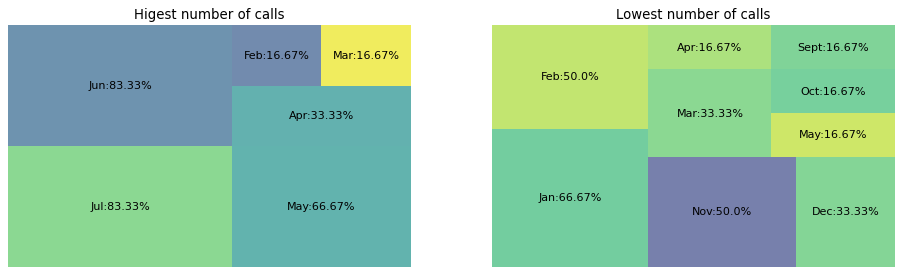

In [1058]:
#Calls
plot_treemap_sidebyside(nc_m,nc_l,'percentage','label','Higest number of calls','Lowest number of calls')


- With above visualization it is clear that Jun, Jul followed by May are the months when there were be more number of calls where as Jan is the month mostly with low number of calls.

### Analysis of used Talk Time
Here in this analysis used talk time is calculated for every month and then figured out the top three months for every year in which the most and least talk time is used. 

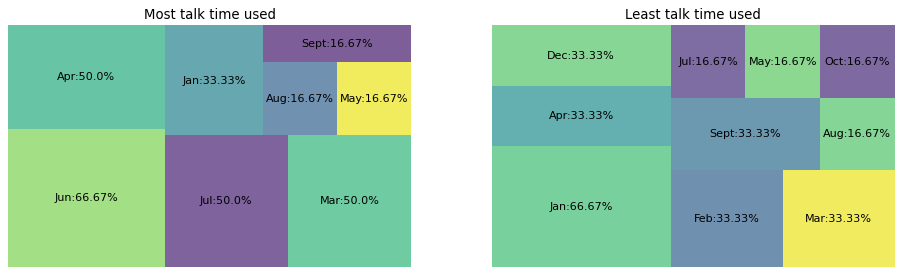

In [16]:
#att_m,att_l
plot_treemap_sidebyside(att_m,att_l,'percentage','label','Most talk time used','Least talk time used')

From above it can be inferred that June is the month which has appeared atleast $4$ times out of $6$ years in top three months where most of the talktime is used whereas January appearing for least talk time used.

### Analysis of Unanswered calls
In this analysis number of unanswered calls counted for every month and then figured out the top three months for every year in which there most and least number of unanswered calls.

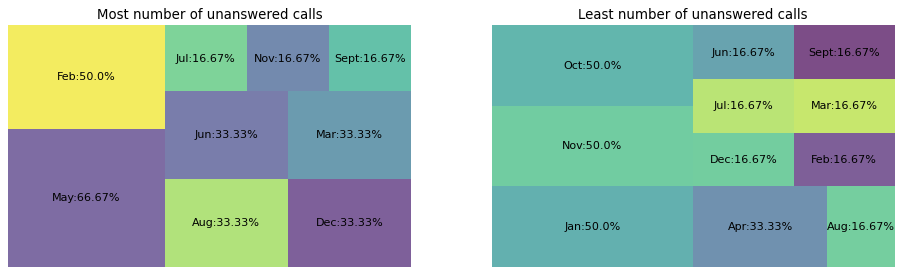

In [1021]:
#UnansStats
plot_treemap_sidebyside(unans_m,unans_l,'percentage','label','Most number of unanswered calls','Least number of unanswered calls')

Here May is the month which is having most number of unanswered calls.


### Correlations in above findings
* **July** has $66.6$% chances of being in one of top $3$ months where *most of the talktime* is used which is also supported by the *number of calls* statistic as it is also among top $3$ months which are having *most number of calls* with $83.33$% chance.
* **January** is among top $3$ months which are having least number of calls and which is supported by its least talk time statistic.
* **May** has the highest chances of landing among top $3$ months which are having *most number of unanswered calls* and also it has $66.67$% of chances of landing among top $3$ months for *most number of calls*. Which suggests that out of all $6$ years $4$ times may has come among top $3$ months which are having both most number of calls and most number of answered calls.


## Analysis on Queue Time.
Here calls from all years have taken together to analyse how many seconds a person is willing to wait before he or she drops the call.  .

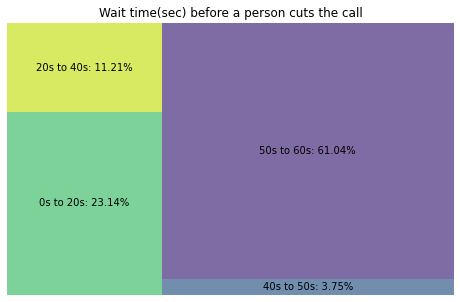

In [1059]:
plot_queuetime_stats(qt_20,qt_19,qt_18,qt_17,qt_16,qt_15)

From above visualization it can be said $61.04$% times people are willing to wait till $50$ to $60$ seconds.  

### Probability of dropping a call after 50 secs when it is known that call has not been dropped during the first 20 sec.

$P = \frac {0.6104}{1-0.2314}=0.7941$

The probability tells us that there are $79.41$% of chances that if person has not dropped a call during the first $20$ seconds then he or she will drop it after $50$ seconds.


*The simulation of above probablity is done in R and code can be found at https://github.com/Abhisheks0ni/NirmaanNGO/blob/main/prob_simulation.R , the result of which gives us confidence that calculated probablity is correct.*  
<br>
<br>
<br>
<br>


**Author**: Abhishek Soni<br>
**Email**:  abhisheksoni@hotmail.com

In [229]:
import ipywidgets as widgets
from IPython.display import display, HTML
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}


def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)

ToggleButton(value=False, description='Show code')